<hr style="color:#DA01B5">

# Introducción al proyecto

<hr style="color:#DA01B5">

El presente trabajo se centra en el estudio matemático de las redes bayesianas como herramienta para la identificación de actividades humanas en entornos ubicuos, caracterizados por la recopilación de datos provenientes de múltiples fuentes heterogéneas. Desde una perspectiva formal, se analizan las propiedades estructurales y probabilísticas de estos modelos, así como su capacidad para representar dependencias condicionales entre variables observables y latentes. El enfoque adoptado se basa en el aprendizaje de patrones de comportamiento a partir de datos sensoriales, modelando las relaciones entre actividades y señales mediante redes bayesianas. 

El estudio se apoya en un conjunto de datos recogidos durante diez días en un entorno inteligente, donde un único habitante fue monitorizado mediante sensores binarios, un suelo inteligente, balizas BLE y un reloj inteligente, registrando 24 clases de actividades distintas. A partir de estos datos, se construyen y analizan modelos probabilísticos que permiten evaluar la eficacia de las redes bayesianas en la predicción y clasificación de actividades.

En este proyecto se intentará modelizar el comportamiento de una persona que vivió en una casa robotizada, generando una gran colección de datos para construir un modelo de creencias y causalidades de sus actividades, *¿Si el habitante se acaba de levantar, qué será lo siguiente que hará?*. Para ello, se implementará una Red Bayesiana y se intentará construir un modelo que estudie su comportamiento en diferentes momentos del día divididos en mañana (A), medio día (B) y tarde (C). 

Al construir un modelo de *Machine Learning* (ML) se debe seguir la siguiente estructura:

1.  **Planteamiento del problema**. Se analiza que problema se desea resolver para decidir el modelo adecuado y seleccionar los datos de interés.
2.  **Análisis exploratorio**. Se analiza que forma tienen los datos, cuales son las variables y si hay errores. Normalmente, los datos generados por sensores están llenos de falsas activaciones y otros problemas. Además en esta sección ya se empiezan a analizar posibles patrones que pueden interesar para el modelo.
3.  **Limpieza de los datos**. Una vez conocidos los datos, se limpian todos los erroes y se guardan en una carpeta separada de los datos originales llamada `Training2`.
4.  **Preparación de datos**. Ya limpiados los datos, y decidido el modelo, se preparan los datos para que estén en un formato más legible y óptimo para el entrenamiento de la red Bayesiana.
5.  **Entrenamiento del modelo**. Se entrena el modelo que se haya decidido con los datos preparados.
6.  **Análisis post-hoc**. Se generaliza el modelo a datos que todavía no se habían leido y se resuelve el problema que se había planteado. Después se analiza la solución del problema que nos ofrece nuestro modelo. 

En este *notebook* se resuelven los 3 primeros pasos, el planteamiento del problema, el análisis exploratorio (AED) y la limpieza de los datos. La preparación de los datos se puede encontrar en el archivo `02_preparacion_datos.py`, y el entrenamiento del modelo en `03_modelo.py`. Finalmente la resolución del problema la podemos encontrar en el Notebook `04_modelo.ipynb`. 

<hr style="color:#DA01B5">

## Planteamiento del problema

<hr style="color:#DA01B5">

En entornos inteligentes o <i>smart homes</i>, la detección automática de actividades humanas es una tarea fundamental para el desarrollo de sistemas de asistencia, monitorización del bienestar y automatización de tareas cotidianas. Estos entornos generan grandes volúmenes de datos heterogéneos procedentes de sensores distribuidos en diferentes ubicaciones, los cuales registran continuamente eventos como movimiento, apertura de puertas, uso de electrodomésticos o patrones de desplazamiento.

El problema concreto que se pretende abordar en este proyecto es:

<blockquote>
<b>Modelizar el comportamiento diario de un habitante de una vivienda inteligente, de forma que sea posible predecir cuál será su siguiente actividad a partir de las observaciones disponibles en un instante dado.</b>
</blockquote>

El objetivo es desarrollar un modelo probabilístico basado en redes bayesianas que permita:

1. <b>Representar las relaciones de dependencia condicional</b> entre actividades y señales recogidas por los sensores.  
2. <b>Capturar patrones temporales</b> de comportamiento en diferentes momentos del día (mañana, mediodía y tarde).  
3. <b>Predecir la siguiente actividad</b> del habitante dado el estado actual de los sensores y la actividad previa.  

Este planteamiento implica abordar varios retos:  

- La heterogeneidad y posible ruido en los datos, derivados de sensores que pueden fallar o activarse falsamente.  
- La necesidad de integrar información de distinta naturaleza (eventos binarios, secuencias temporales, ubicaciones en el suelo inteligente).  
- La escasez de repeticiones de algunas actividades, lo que obliga a construir un modelo que no dependa únicamente de la frecuencia observada.  

En resumen, se busca construir una representación probabilística que permita inferir, con un cierto grado de certeza, las acciones futuras del habitante y las causas más probables de sus comportamientos, apoyándose en las capacidades de las redes bayesianas para manejar incertidumbre y relaciones causales.


<hr style="color:#DA01B5">

## Análisis exploratorio


<hr style="color:#DA01B5">

In [29]:
# Cargamos las dependencias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import seaborn as sns
import datetime
import shutil
import os
from funciones import *

# Guardamos en una lista los días de entrenamiento
days = ['2017-10-31', '2017-11-02', '2017-11-03', '2017-11-08', '2017-11-10', '2017-11-15', '2017-11-20']

<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;"> Descripción de la base de datos </h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>

Como se ha mencionado, los datos provienen de un experimento que se realizó en una casa robotizada y guardan la información de los momentos en los que se activaban y desactivaban los sensores, los cuales se describirán más adelante. 

Primero de todo, se desglosa de qué manera están organizados los datos:

``` Data/
Data/
├── Test/
│   ├── 2017-11-9/
│   │   ├── 2017-11-9-A/
│   │   │   ├── 2017-11-9-A-acceleration.csv
│   │   │   ├── 2017-11-9-A-floor.csv
│   │   │   ├── 2017-11-9-A-proximity.csv     
│   │   │   └── 2017-11-9-A-sensors.csv
│   │   ├── 2017-11-9-B     
│   │   └── 2017-11-9-C
│   ├── 2017-11-13
│   └── 2017-11-21
└── Train/
    ├── 2017-10-31/
    │   ├── 2017-10-31-A/
    │   │   ├── 2017-10-31-A-acceleration.csv
    │   │   ├── 2017-10-31-A-activity.csv
    │   │   ├── 2017-10-31-A-floor.csv
    │   │   ├── 2017-10-31-A-proximity.csv     
    │   │   └── 2017-10-31-A-sensors.csv
    │   ├── 2017-10-31-B     
    │   └── 2017-10-31-C
    ├── 2017-11-02
    ├── 2017-11-03
    ├── 2017-11-08
    ├── 2017-11-10
    ├── 2017-11-15
    └── 2017-11-20

Como se puede observar, es un conjunto de datos de gran tamaño, el cual se debe entender bien si se quiere aplicar correctamente el modelo. 

En primer lugar, se analiza la carpeta `Train`, donde se encuentran 7 días, cada día dividido en `A`, `B` y `C`; lo cual corresponde a mañana, mediodía y tarde respectivamente. En cada una de estas secciones del día se puede encontrar los siguientes 5 archivos `.csv`:

* (...)-**acceleration.csv**: Contiene datos recogidos por el acelerómetro del smartwatch del habitante a 50 Hz. Tiene 4 columnas: TIMESTAMP, X, Y y Z, donde X, Y y Z son aceleraciones en m/s² en los tres ejes. Solo se registran cuando el sujeto está activo (no durmiendo ni fuera del laboratorio).

* (...)-**activity.csv**: Archivo con 4 columnas: DATE BEGIN, DATE END, ACTIVITY y HABITANT. Marca el inicio y fin de cada actividad etiquetada manualmente mediante etiquetas NFC y un smartphone. El habitante siempre es “Mario” en este conjunto.

* (...)-**floor.csv**: Datos de un suelo inteligente SensFloor® con 40 módulos distribuidos en 4 filas y 10 columnas. Cada módulo tiene 8 sensores capacitivos. Columnas: TIMESTAMP (instante de lectura), DEVICE (identificador de módulo) y CAPACITANCE (valores de los 8 sensores de ese módulo). Sirve para localizar y seguir el movimiento del habitante dentro de la vivienda.

* (...)-**proximity.csv**: Datos recogidos por el smartwatch midiendo la intensidad de señal recibida (RSSI) desde 15 balizas Bluetooth Low Energy (BLE) colocadas en objetos y zonas de la casa. Columnas: TIMESTAMP, ID (baliza), OBJECT (objeto asociado) y RSSI. Permite estimar la proximidad del habitante a cada objeto/zona.

* (...)-**sensors.csv**: Eventos de 30 sensores binarios distribuidos en la vivienda (magnéticos, de movimiento PIR y de presión). Columnas: TIMESTAMP, OBJECT (identificador de sensor), STATE (estado, p. ej., abierto/cerrado, movimiento/no movimiento, presión/no presión) y HABITANT (siempre “Mario”). Detecta interacciones del habitante con objetos y estancias.

La carpeta `Test` tiene la misma estructura únicamente para 3 días que no están en `Train`. En estos días no está el archivo `(...)-activity.csv`. Esto se debe a que el objetivo de este proyecto, es construir un modelo con el conjunto `Train` que nos permita predecir la actividad. 

<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;"> Actividades </h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>

A continuación, se realiza un análisis de los datos relacionados con las actividades recogidos en los archivos `(...)-activity.csv`.

**ACTIVIDADES REALIZADAS A LO LARGO DE LOS DÍAS**

Como para el problema se quiere analizar las actividades del habitante, se observa cúales han sido las actividades que ha realizado de manera global a lo largo de todos los días, únicamente en el momento A, únicamente en el momento B y únicamente en el momento C.

In [30]:
# Definimos un conjunto que nos diga todas las actividades que ha realizado Mario a lo largo de todos los días
global_activities_A = set()
global_activities_B = set()
global_activities_C = set()
global_activities = set()
# Iteramos sobre los días y letras para cargar las actividades
for day in days:
    for letter in ['A', 'B', 'C']:
        activity = load_file(day, letter, file_type='activity', dset='Training')
        if letter == 'A':
            global_activities_A.update(set(activity['ACTIVITY']))
        elif letter == 'B':
            global_activities_B.update(set(activity['ACTIVITY']))
        elif letter == 'C':
            global_activities_C.update(set(activity['ACTIVITY']))

global_activities = global_activities_A.union(global_activities_B).union(global_activities_C)

print("\033[1;32mActividades globales de Mario:\033[0m", list(global_activities))
print("\033[1;32mActividades de Mario por la mañana:\033[0m", list(global_activities_A))
print("\033[1;32mActividades de Mario al medio día:\033[0m", list(global_activities_B))
print("\033[1;32mActividades de Mario por la tarde:\033[0m", list(global_activities_C))
print("\033[1;33mNúmero total de actividades:\033[0m", len(global_activities))

Actividades globales de Mario: ['Act20', 'Act14', 'Act15', 'Act11', 'Act01', 'Act03', 'Act12', 'Act02', 'Act10', 'Act09', 'Act22', 'Act07', 'Act08', 'Act04', 'Act05', 'Act19', 'Act17', 'Act16', 'Act21', 'Act24', 'Act23', 'Act06', 'Act13', 'Act18']
Actividades de Mario por la mañana: ['Act05', 'Act20', 'Act17', 'Act16', 'Act21', 'Act24', 'Act13', 'Act02', 'Act22', 'Act18']
Actividades de Mario al medio día: ['Act20', 'Act14', 'Act15', 'Act01', 'Act03', 'Act12', 'Act10', 'Act09', 'Act22', 'Act08', 'Act19', 'Act17', 'Act06', 'Act13', 'Act18']
Actividades de Mario por la tarde: ['Act15', 'Act11', 'Act01', 'Act10', 'Act07', 'Act22', 'Act04', 'Act19', 'Act17', 'Act23', 'Act18']
Número total de actividades: 24


Como se puede observar, realiza distintas actividades en función del día, y en total hay 24 actividades registradas. 

**TABLA DE TODAS LAS ACTIVIDADES**

| Activity's ID | Activity's Name                          |
|:-------------:|:---------------------------------------- |
| Act01         | Take medication                          |
| Act02         | Prepare breakfast                        |
| Act03         | Prepare lunch                            |
| Act04         | Prepare dinner                           |
| Act05         | Breakfast                                |
| Act06         | Lunch                                    |
| Act07         | Dinner                                   |
| Act08         | Eat a snack                              |
| Act09         | Watch TV                                 |
| Act10         | Enter the SmartLab                       |
| Act11         | Play a videogame                         |
| Act12         | Relax on the sofa                        |
| Act13         | Leave the SmarLab                        |
| Act14         | Visit in the SmartLab                    |
| Act15         | Put waste in the bin                     |
| Act16         | Wash hands                               |
| Act17         | Brush teeth                              |
| Act18         | Use the toilet                           |
| Act19         | Wash dishes                              |
| Act20         | Put washing into the washing machine     |
| Act21         | Work at the table                        |
| Act22         | Dressing                                 |
| Act23         | Go to the bed                            |
| Act24         | Wake up                                  |

**FRECUENCIA DE LAS ACTIVIDADES**

In [31]:
# Calculamos las frecuencias de las actividades
sorted_activities = sorted(list(global_activities), key=lambda x: int(x[3:]))  # Ordenamos las actividades por el número
frequencies = {activity: 0 for activity in sorted_activities}
for day in days:
    for letter in ['A', 'B', 'C']:
        activity = load_file(day, letter, file_type='activity', dset='Training')
        activity_counts = activity['ACTIVITY'].value_counts()
        for act in sorted_activities:
            frequencies[act] += activity_counts.get(act, 0)
# Mostramos las frecuencias de las actividades
print("\033[1;34mFrecuencias de las actividades:\033[0m")
for activity, freq in sorted(frequencies.items(), key=lambda x: x[1], reverse=True):
    print(f"{activity}: {freq}")

Frecuencias de las actividades:
Act17: 21
Act22: 15
Act10: 12
Act15: 11
Act18: 10
Act13: 9
Act01: 7
Act02: 7
Act04: 7
Act05: 7
Act07: 7
Act23: 7
Act24: 7
Act03: 6
Act06: 6
Act09: 6
Act16: 6
Act20: 6
Act08: 5
Act19: 2
Act21: 2
Act11: 1
Act12: 1
Act14: 1


Se observa que las actividades que realiza Mario con más frecuencia son: *lavarse los dientes (Act17)*, *vestirse (Act22)*, *entrar al SmartLab (Act10)*, *tirar basura (Act15)* y *usar el baño (act18)*. También hay actividades que ha realizado muy poco, como por ejemplo, *jugar a videojuegos (Act11)*, *relajarse en el sofa (Act12)*, *visitar el SmartLab (Act14)*, *lavar los platos (Act19)* y *trabajar en la mesa (Act21)*. El resto de actividades rondan una frecuencia de 6.

El objetivo es modelizar estas actividades a partir de los datos que ofrece la casa. Para ello se procede con el análisis del resto de archivos.

**Acelerómetro**

Datos originales:
                TIMESTAMP         X          Y         Z
0 2017-11-20 13:27:58.685  4.710205 -10.730560  3.053207
1 2017-11-20 13:27:58.704  4.619751  -9.546326  3.062729
2 2017-11-20 13:27:58.724  4.813751  -9.473724  1.821365
3 2017-11-20 13:27:58.742  4.290070  -9.251160  1.641647
4 2017-11-20 13:27:58.763  4.337677  -8.673920  1.971329


Datos con tiempo normalizado:
                TIMESTAMP         X          Y         Z  tiempo_segundos  \
0 2017-11-20 13:27:58.685  4.710205 -10.730560  3.053207            0.000   
1 2017-11-20 13:27:58.704  4.619751  -9.546326  3.062729            0.019   
2 2017-11-20 13:27:58.724  4.813751  -9.473724  1.821365            0.039   
3 2017-11-20 13:27:58.742  4.290070  -9.251160  1.641647            0.057   
4 2017-11-20 13:27:58.763  4.337677  -8.673920  1.971329            0.078   

   tiempo_normalizado  
0             0.00000  
1             0.00001  
2             0.00002  
3             0.00003  
4             0.00004  


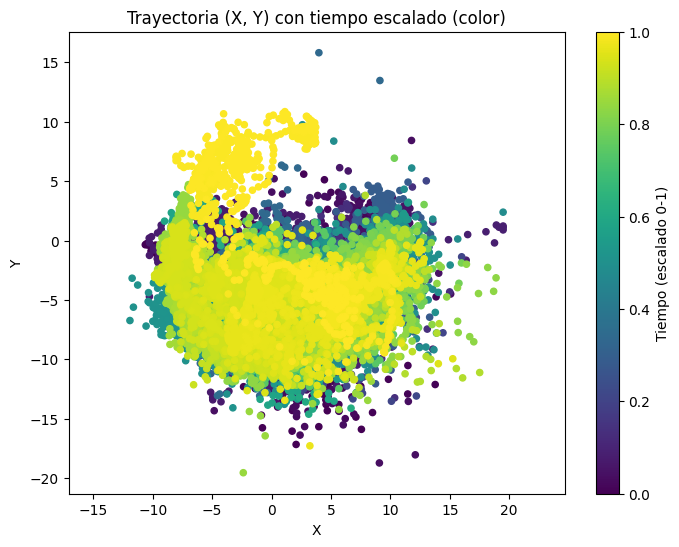

In [32]:
i, letter = 6, 'B'
df = load_file(days[i], letter, file_type='acceleration', dset='Training')

# Asegúrate de que los nombres de las columnas coincidan con los de tu archivo
# Por ejemplo: 'Time', 'X', 'Y', 'Z'
# Si no, usa df.columns para ver los nombres y ajusta el código

# Escalar el tiempo entre 0 y 1
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
print("\033[1;35mDatos originales:\033[0m")
print(df.head())

df['tiempo_segundos'] = (df['TIMESTAMP'] - df['TIMESTAMP'].min()).dt.total_seconds()

# 3. Normalizar entre 0 y 1
min_t = df['tiempo_segundos'].min()
max_t = df['tiempo_segundos'].max()
df['tiempo_normalizado'] = (df['tiempo_segundos'] - min_t) / (max_t - min_t)

t = df['tiempo_normalizado']
print("\n")
print("\033[1;36mDatos con tiempo normalizado:\033[0m")
print(df.head())


# Normalizamos el tiempo entre 0 y 1
t_scaled = (t - t.min()) / (t.max() - t.min())

# Crear la gráfica
plt.figure(figsize=(8, 6))
sc = plt.scatter(df['X'], df['Y'], c=t_scaled, cmap='viridis', s=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trayectoria (X, Y) con tiempo escalado (color)')
plt.colorbar(sc, label='Tiempo (escalado 0-1)')
plt.axis('equal')
plt.show()

<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;">Suelo</h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>


El suelo estaba dividido en una cuadrícula de *5x10*, dispuesta de unos sensores que permitían indicar en qué posición estaba el habitante. 

En la siguiente gráfica se observa una imagen de la casa y de los sensores que tenía.

<div style="text-align: center;">
  <img src="plots/casa.png" alt="Esquema de la casa" width="600">
</div>

<div style="text-align: center;">
  <img src="plots/SensoresFloor.png" alt="Localización sensores" width="600">
</div>

**5 PRIMERAS FILAS DEL DF `2017-10-31-A-floor.csv`**

Se analizan las distintas placas que se activan y desactivan según las actividades, tomando, por ejemplo, el primer día en el momento A.

In [33]:
i, letter = 0, 'A'
df_floor = load_file(days[i], letter, 'floor')
print('\033[1;34mDataFrame Floor 31/10/2017:\033[0m')
print(df_floor.head())

DataFrame Floor 31/10/2017:
             TIMESTAMP DEVICE                                   CAPACITANCE
0  2017/10/31 11:12:46  01,09   0.00,0.00,-1.00,-1.00,0.00,-3.00,-1.00,0.00
1  2017/10/31 11:12:47  01,09   0.00,0.00,-1.00,-1.00,0.00,-1.00,-1.00,0.00
2  2017/10/31 11:12:47  01,09   0.00,0.00,-2.00,-1.00,0.00,-3.00,-1.00,0.00
3  2017/10/31 11:13:36  01,07   0.00,-1.00,-2.00,1.00,0.00,0.00,11.00,-2.00
4  2017/10/31 11:13:36  01,07  1.00,-1.00,-2.00,-1.00,0.00,-1.00,0.00,-3.00


Como se puede observar se dispone de 3 variables, `TIMESTAMP`, `DEVICE` y `CAPACITANCE`. 
* El tiempo `TIMESTAMP` indica en qué momento ha sido activada una placa, 
* `DEVICE` indica las coordenadas de la placa activada. 
* La última variable `CAPACITANCE` es un poco más complicada, ya que se trata de un vector de longitud 8 que toma valores enteros y que mide el cambio de carga eléctrica. Así, se considera que cuando hay un cambio es por la presencia de Mario.

**GIF DEL DÍA 31-10-2017 MOMENTO A**

In [34]:
# NORMALIZAMOS LOS TIEMPOS PARA HACER EL GIF
df_recorrido = df_floor[['TIMESTAMP','DEVICE']]

# Escalamos los tiempos en el recorrido de 0 a 1 para poder visualizar el recorrido:
df_recorrido['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
print("\033[1;35mDatos originales:\033[0m")
print(df_recorrido.head())

df_recorrido['tiempo_segundos'] = (df_recorrido['TIMESTAMP'] - df_recorrido['TIMESTAMP'].min()).dt.total_seconds()

# 3. Normalizar entre 0 y 1
min_t = df_recorrido['tiempo_segundos'].min()
max_t = df_recorrido['tiempo_segundos'].max()
df_recorrido['tiempo_normalizado'] = (df_recorrido['tiempo_segundos'] - min_t) / (max_t - min_t)

df_recorrido = df_recorrido.drop(['tiempo_segundos', 'TIMESTAMP'], axis=1)
print("\033[1;35mDatos con tiempo escalado:\033[0m")
print(df_recorrido.head())


Datos originales:
                TIMESTAMP DEVICE
0 2017-11-20 13:27:58.685  01,09
1 2017-11-20 13:27:58.704  01,09
2 2017-11-20 13:27:58.724  01,09
3 2017-11-20 13:27:58.742  01,07
4 2017-11-20 13:27:58.763  01,07
Datos con tiempo escalado:
  DEVICE  tiempo_normalizado
0  01,09            0.000000
1  01,09            0.000233
2  01,09            0.000479
3  01,07            0.000700
4  01,07            0.000959


C:\Users\sheil\AppData\Local\Temp\ipykernel_22168\1557013149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recorrido['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])


In [35]:
r"""
# Creamos una animación del recorrido por las distintas placas
# === 2. Convertir DEVICE a coordenadas ===
df_recorrido[['row', 'col']] = df_recorrido['DEVICE'].str.split(',', expand=True).astype(int)

# Opcional: ajustar coordenadas para que empiecen en 0
df_recorrido['row'] = df_recorrido['row'] - 1
df_recorrido['col'] = df_recorrido['col'] - 1

# Valores que toma la fila:
print(f"\033[1;32mValores fila:\033[0m ", list(set(list(df_recorrido['row']))))
print(f"\033[1;32mValores columna:\033[0m ", list(set(list(df_recorrido['col']))))
print(f"\033[1mLongitud dataset:\033[0m", len(df_recorrido))
# === 3. Crear la figura ===
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlim(-0.5, 9.5)  # columnas de 0 a 8
ax.set_ylim(-0.5, 4.5)  # filas de 0 a 4
ax.set_xticks(range(9))
ax.set_yticks(range(5))
ax.grid(True)

# Crear el punto inicial
point, = ax.plot([], [], 'bo', markersize=10)

# === 4. Funciones de animación ===
def init():
    point.set_data([], [])
    return point,

def update(frame):
    r = df_recorrido.loc[frame, 'row']
    c = df_recorrido.loc[frame, 'col']
   
    point.set_data([c], [r])
    return point,

# === 5. Crear la animación ===
anim = FuncAnimation(
    fig, update, frames=len(df_recorrido),
    init_func=init, blit=True, interval=300  # interval en ms
)

# === 6. Guardar como GIF ===
anim.save('recorrido2.gif', writer=PillowWriter(fps=60))
plt.close()

print("GIF guardado como 'recorrido2.gif'")
"""

'\n# Creamos una animación del recorrido por las distintas placas\n# === 2. Convertir DEVICE a coordenadas ===\ndf_recorrido[[\'row\', \'col\']] = df_recorrido[\'DEVICE\'].str.split(\',\', expand=True).astype(int)\n\n# Opcional: ajustar coordenadas para que empiecen en 0\ndf_recorrido[\'row\'] = df_recorrido[\'row\'] - 1\ndf_recorrido[\'col\'] = df_recorrido[\'col\'] - 1\n\n# Valores que toma la fila:\nprint(f"\\033Valores fila:\\033 ", list(set(list(df_recorrido[\'row\']))))\nprint(f"\\033Valores columna:\\033 ", list(set(list(df_recorrido[\'col\']))))\nprint(f"\\033Longitud dataset:\\033", len(df_recorrido))\n# === 3. Crear la figura ===\nfig, ax = plt.subplots(figsize=(10, 4))\nax.set_xlim(-0.5, 9.5)  # columnas de 0 a 8\nax.set_ylim(-0.5, 4.5)  # filas de 0 a 4\nax.set_xticks(range(9))\nax.set_yticks(range(5))\nax.grid(True)\n\n# Crear el punto inicial\npoint, = ax.plot([], [], \'bo\', markersize=10)\n\n# === 4. Funciones de animación ===\ndef init():\n    point.set_data([], [])\n 

<div style="text-align: center;">
  <img src="recorrido2.gif" alt="Localización sensores" width="600">
</div>

Se puede observar como mayoritariamente esta por la zona de arriba a la izquierda, lo cual corresponde a la cocina como indica la imagen mostrada anteriormente. También hay algunos saltos a  la zona de abajo a la derecha, que se debe analizar si realmente son saltos o simplemente por la velocidad no lo percibimos. Este problema se trata en la limpieza de los datos.

**DIAGRAMA DE FRECUENCIAS DE CADA ACTIVIDAD**

Ahora se quiere visualizar qué actividad estaba realizando en cada zona. Para ello se muestra un diagrama de frecuencias de cada actividad a lo largo de todas los días. 

In [36]:
devices = [ f"0{i+1},0{j+1}" for i in range(5) for j in range(10) ]  # Asumiendo 5 filas y 9 columnas
freq = {act: {dev: 0 for dev in devices} for act in sorted_activities}

# Contar la frecuencia de cada dispositivo por actividad
for day in days:
    for letter in ['A', 'B', 'C']:
        df_floor = load_file(day, letter, 'floor', dset='Training')
        actividades = load_file(day, letter, 'activity', dset='Training')

        # Convertir TIMESTAMP a datetime
        df_floor['TIMESTAMP'] = pd.to_datetime(df_floor['TIMESTAMP'], errors='coerce')
        actividades['DATE BEGIN'] = pd.to_datetime(actividades['DATE BEGIN'], errors='coerce')
        actividades['DATE END'] = pd.to_datetime(actividades['DATE END'], errors='coerce')

        # Eliminamos las filas de floor con DEVICE '02,0A' o '01,0A'
        df_floor = df_floor[~df_floor['DEVICE'].isin(['02,0A', '01,0A'])]

        devic_day = list(df_floor['DEVICE'])
        timestamp_day = list(df_floor['TIMESTAMP'])

        activ_day = actividades['ACTIVITY'].unique()
        # Creamos un diccionario para almacenar los intervalos de cada actividad
        dic2 = {act: [] for act in activ_day}
        # Iteramos sobre las actividades y sus intervalos
        for i in range(len(actividades)):
            act = actividades.loc[i, 'ACTIVITY']
            start = actividades.loc[i, 'DATE BEGIN']
            end = actividades.loc[i, 'DATE END']
            dic2[act].append((start, end))

        # Iteramos sobre el data frame de floor
        for i in range(len(df_floor)):
            # Miramos que device esta y que actividad esta
            device = devic_day[i]
            timestamp = timestamp_day[i]
            
            # Comprobamos si el timestamp está dentro de algún intervalo de actividad
            for act, intervals in dic2.items():
                for start, end in intervals:
                    if start <= timestamp <= end:
                        freq[act][device] += 1
                        


<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sheil\AppData\Local\Temp\ipykernel_22168\1795013363.py:16: SyntaxWarning: invalid escape sequence '\d'
  conteo['X'] = conteo['X_raw'].str.extract('(\d+)').astype(int)
C:\Users\sheil\AppData\Local\Temp\ipykernel_22168\1795013363.py:17: SyntaxWarning: invalid escape sequence '\d'
  conteo['Y'] = conteo['Y_raw'].str.extract('(\d+)').astype(int)


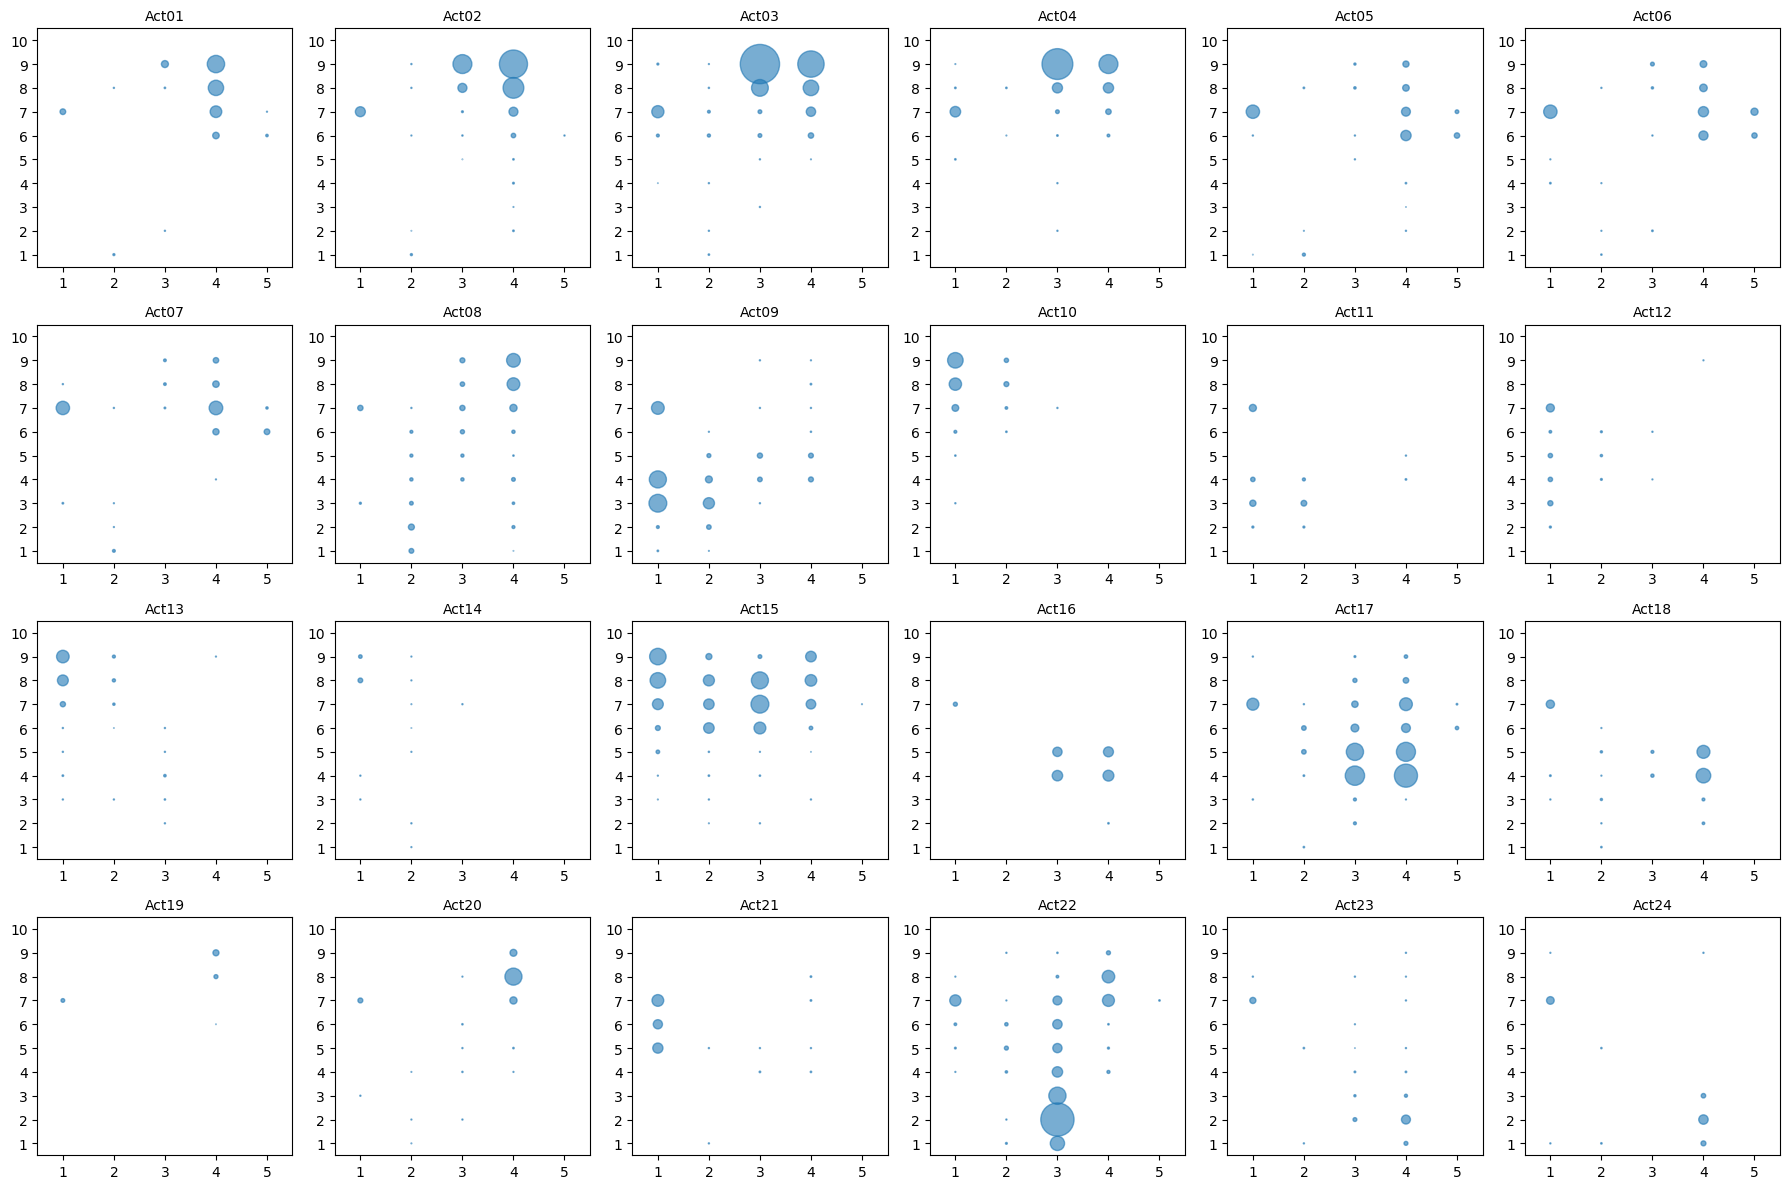

In [37]:
# Normalizamos las frecuencias
max_freq = max(max(freq[act].values()) for act in freq)
for act in freq:
    for dev in freq[act]:
        freq[act][dev] = 100*freq[act][dev]/max_freq
# Definimos el dataframe conteo de frecuencias
# Definimos el DataFrame con 3 variables: 'Activity', 'DEVICE' y 'Count'
conteo = pd.DataFrame([(act, dev, freq[act][dev]) for act in sorted_activities for dev in devices],
                      columns=['Activity', 'DEVICE', 'Count'])
# Asegurar que DEVICE se separa en dos coordenadas X,Y (asumiendo "02,05" significa x=2, y=5)
# conteo[['X', 'Y']] = conteo['DEVICE'].str.split(',', expand=True).astype(int)
# Extraer solo dígitos en X y Y (por ejemplo "0A" -> "0")
conteo[['X_raw', 'Y_raw']] = conteo['DEVICE'].str.split(',', expand=True)

# Extraer solo los dígitos (remover letras)
conteo['X'] = conteo['X_raw'].str.extract('(\d+)').astype(int)
conteo['Y'] = conteo['Y_raw'].str.extract('(\d+)').astype(int)


# Número de actividades para definir el grid de subplots
acts = conteo['Activity'].unique()
n_acts = len(acts)
cols = 6  # número de columnas en el grid
rows = (n_acts + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()

for idx, act in enumerate(sorted(acts)):
    ax = axes[idx]
    df_act = conteo[conteo['Activity'] == act]
    ax.scatter(df_act['X'], df_act['Y'], s=df_act['Count']*8, alpha=0.6)
    ax.set_title(act, fontsize=10)
    ax.set_xlim(0.5, 5.5)
    ax.set_ylim(0.5, 10.5)
    ax.set_xticks(range(1, 6))
    ax.set_yticks(range(1, 11))

# Quitar ejes vacíos
for i in range(idx+1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [54]:
# Obtener top 3 devices por actividad
top_devices = (
    conteo
    .sort_values(['Activity', 'Count'], ascending=[True, False])  # Ordenar por actividad y frecuencia descendente
    .groupby('Activity')  # Agrupar por actividad
    .head(3)  # Tomar los 3 primeros de cada grupo
)

# Si quieres como diccionario {actividad: [device1, device2, device3]}
top_devices_dict = (
    top_devices.groupby('Activity')['DEVICE']
    .apply(list)
    .to_dict()
)

print(top_devices_dict)

import json

# Guardar en JSON
with open("../Red Bayesiana/top_devices.json", "w") as f:
    json.dump(top_devices_dict, f, indent=4)


{'Act01': ['04,09', '04,08', '04,07'], 'Act02': ['04,09', '04,08', '03,09'], 'Act03': ['03,09', '04,09', '03,08'], 'Act04': ['03,09', '04,09', '01,07'], 'Act05': ['01,07', '04,06', '04,07'], 'Act06': ['01,07', '04,07', '04,06'], 'Act07': ['04,07', '01,07', '04,08'], 'Act08': ['04,09', '04,08', '04,07'], 'Act09': ['01,03', '01,04', '01,07'], 'Act10': ['01,09', '01,08', '01,07'], 'Act11': ['01,07', '01,03', '02,03'], 'Act12': ['01,07', '01,03', '01,04'], 'Act13': ['01,09', '01,08', '01,07'], 'Act14': ['01,08', '01,09', '01,03'], 'Act15': ['03,07', '03,08', '01,09'], 'Act16': ['04,04', '03,04', '04,05'], 'Act17': ['04,04', '03,04', '04,05'], 'Act18': ['04,04', '04,05', '01,07'], 'Act19': ['04,09', '04,08', '01,07'], 'Act20': ['04,08', '04,07', '04,09'], 'Act21': ['01,07', '01,05', '01,06'], 'Act22': ['03,02', '03,03', '03,01'], 'Act23': ['04,02', '01,07', '04,01'], 'Act24': ['04,02', '01,07', '04,01']}


<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;">Sensores</h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>

**SENSORES A LO LARGO DE LOS DÍAS**

Los sensores son uno de los objetos más importantes para el estudio. Al igual que antes, se analiza qué sensores tenemos y en qué momentos del día se han activado.

In [38]:
# Definimos un conjunto que nos diga todas las actividades que ha realizado Mario a lo largo de todos los días
global_sensors_A = set()
global_sensors_B = set()
global_sensors_C = set()
global_sensors = set()
# Iteramos sobre los días y letras para cargar las actividades
for day in days:
    for letter in ['A', 'B', 'C']:
        sensors = load_file(day, letter, file_type='sensors', dset='Training')
        if letter == 'A':
            global_sensors_A.update(set(sensors['OBJECT']))
        elif letter == 'B':
            global_sensors_B.update(set(sensors['OBJECT']))
        elif letter == 'C':
            global_sensors_C.update(set(sensors['OBJECT']))

global_sensors = global_sensors_A.union(global_sensors_B).union(global_sensors_C)

print("\033[1;32mSensores globales de Mario:\033[0m", list(global_sensors))
print("\033[1;33m      Número de sensores:\033[0m", len(global_sensors))
print("\033[1;32mSensores de Mario por la mañana:\033[0m", list(global_sensors_A))
print("\033[1;33m      Número de sensores por la mañana:\033[0m", len(global_sensors_A))
print("\033[1;32mSensores de Mario por la tarde:\033[0m", list(global_sensors_B))
print("\033[1;33m      Número de sensores por la tarde:\033[0m", len(global_sensors_B))
print("\033[1;32mSensores de Mario por la noche:\033[0m", list(global_sensors_C))
print("\033[1;33m      Número de sensores por la noche:\033[0m", len(global_sensors_C))


Sensores globales de Mario: ['C07', 'D07', 'SM5', 'C14', 'D09', 'C05', 'D08', 'SM4', 'C08', 'C02', 'C09', 'D01', 'SM3', 'C10', 'D02', 'C01', 'D10', 'D04', 'SM1', 'C13', 'C12', 'M01', 'TV0', 'C04', 'S09', 'H01', 'D05', 'D03']
      Número de sensores: 28
Sensores de Mario por la mañana: ['SM3', 'C07', 'D07', 'C14', 'C10', 'D09', 'D02', 'SM4', 'D10', 'SM1', 'C08', 'C12', 'D04', 'C13', 'M01', 'C04', 'H01', 'C09', 'D01', 'D03']
      Número de sensores por la mañana: 20
Sensores de Mario por la tarde: ['D07', 'SM5', 'D09', 'D08', 'SM4', 'C08', 'C02', 'C09', 'D01', 'SM3', 'C10', 'D02', 'C01', 'D10', 'D04', 'SM1', 'C12', 'M01', 'TV0', 'C04', 'S09', 'D05', 'D03']
      Número de sensores por la tarde: 23
Sensores de Mario por la noche: ['C07', 'SM5', 'D07', 'C14', 'C05', 'D08', 'SM4', 'C08', 'C09', 'D01', 'SM3', 'C10', 'D02', 'C01', 'D10', 'D04', 'SM1', 'C13', 'M01', 'TV0', 'C04', 'D05', 'D03']
      Número de sensores por la noche: 23


**5 PRIMERAS FILAS DEL DF `2017-10-31-A-sensors.csv`**

Como se puede observar, hay un total de 28 sensores, y en cada momento del día se activan practicamente todos. En la siguiente tabla se muestra el significado de cada sensor. Para los sensores es más complicado realizar una lista de frecuencias, ya que se van activando y desactivando. 

In [39]:
day= '2017-11-02'
letter = 'A'
DF = load_file(day, letter, file_type='sensors', dset='Training')
DF.head(5)

,TIMESTAMP,OBJECT,STATE,HABITANT
0,2017/11/02 10:05:08.0,C14,Pressure,Mario
1,2017/11/02 10:05:10.0,C14,No Pressure,Mario
2,2017/11/02 10:05:23.0,C14,No Pressure,Mario
3,2017/11/02 10:05:26.0,C14,Pressure,Mario
4,2017/11/02 10:05:29.0,C14,No Pressure,Mario


**TABLA DE TODOS LOS SENSORES**

In [40]:
print("\n\033[1;32mSensores registrados:\033[0m")
print(sorted(list(global_sensors)))


Sensores registrados:
['C01', 'C02', 'C04', 'C05', 'C07', 'C08', 'C09', 'C10', 'C12', 'C13', 'C14', 'D01', 'D02', 'D03', 'D04', 'D05', 'D07', 'D08', 'D09', 'D10', 'H01', 'M01', 'S09', 'SM1', 'SM3', 'SM4', 'SM5', 'TV0']


| Sensor  | Descripción     |
|---------|---------------------------------|
| C01     |Caja medicación                       |
| C02     |Bandeja de fruta                 |
| C04     |Pots                                 |
| C05     |Botella de agua                                 |
| C07     |Mando XBOX                                 |
| C08     |Basura                                 |
| C09     |Grifo                                 |
| C10     |Cisterna                                 |
| C12     |Cesto de ropa                                 |
| C13     |Vestidor pijama                                 |
| C14     |Cama                                 |
| D01     |Nevera                                 |
| D02     |Microondas                                 |
| D03     |Guardaropa                                 |
| D04     |Tazas                                 |
| D05     |Lavaplatos                                 |
| D07     |Tapa water                                 |
| D08     |Armario                                 |
| D09     |Lavadora                                 |
| D10     |Despensa                                 |
|H01|Tetera|
|M01|Puerta|
|S09|Pressión sofa|
|SM1|Sensor movimiento cocina|
|SM3|Sensor movimiento baño|
|SM4|Sensor movimiento dormitorio|
|SM5|Sensor movimiento sofa|
|TV0|Televisión|

¿Cuando empiezan y acaban las lecturas de los sensores? Los sensores se diferencian en tres tipos:

* `NPr-Pr`: Estos sensores corresponden a los que se activan y desactivan por `No present` y `Present` respectivamente. En este gruppo se encuentran los sensores: `C07` y `C12`.

* `Pr-NPr`: Estos sensores corresponden a los que se activan y desactivan por `pressure` y `no-pressure`. En este grupo se encuentran los sensores: `C14` y `S09`,

* `M-NM`: Estos sensores corresponden a los de movimiento, i.e., aquellos que se activan y desactivan por `movement` y `no-movement`. Este tipo de sensores suelen tener más errores de lectura. En este grupo se encuentran los sensores: `SM1`, `SM2`, `SM3`, `SM4` y `SM5`

* `O-C`: Estos sensores corresponden a los que se activan y desactivan por `Open` y `Close` respectivamente. En este grupo se encuentra el resto de sensores.

A continuación, se crea un diccionario en el que todos estos formatos pasan a ser únicamente `Open` y `Close`.

In [41]:
# Guardamos en un diccionario que debe tener un sensor para activarse y desactivarse.

sensor_open_close = {
    'C01': {'open': 'Open', 'close': 'Close'}, 
    'C02': {'open': 'Open', 'close': 'Close'}, 
    'C04': {'open': 'Open', 'close': 'Close'}, 
    'C05': {'open': 'Open', 'close': 'Close'}, 
    'C07': {'open': 'No present', 'close': 'Present'}, 
    'C08': {'open': 'Open', 'close': 'Close'}, 
    'C09': {'open': 'Open', 'close': 'Close'}, 
    'C10': {'open': 'Open', 'close': 'Close'}, 
    'C12': {'open': 'No present', 'close': 'Present'}, 
    'C13': {'open': 'Open', 'close': 'Close'}, 
    'C14': {'open': 'Pressure', 'close': 'No Pressure'}, 
    'D01': {'open': 'Open', 'close': 'Close'}, 
    'D02': {'open': 'Open', 'close': 'Close'}, 
    'D03': {'open': 'Open', 'close': 'Close'}, 
    'D04': {'open': 'Open', 'close': 'Close'}, 
    'D05': {'open': 'Open', 'close': 'Close'}, 
    'D07': {'open': 'Open', 'close': 'Close'}, 
    'D08': {'open': 'Open', 'close': 'Close'}, 
    'D09': {'open': 'Open', 'close': 'Close'}, 
    'D10': {'open': 'Open', 'close': 'Close'}, 
    'H01': {'open': 'Open', 'close': 'Close'}, 
    'M01': {'open': 'Open', 'close': 'Close'}, 
    'S09': {'open': 'Pressure', 'close': 'No Pressure'}, 
    'SM1': {'open': 'Movement', 'close': 'No movement'}, 
    'SM3': {'open': 'Movement', 'close': 'No movement'}, 
    'SM4': {'open': 'Movement', 'close': 'No movement'}, 
    'SM5': {'open': 'Movement', 'close': 'No movement'}, 
    'TV0': {'open': 'Open', 'close': 'Close'}
}

**ERRORES DE LECTURA**

Si se observan los datos, se aprecia que hay algunos errores de lectura como puede ser que el sensor se active dos veces seguidas. Por ello, hay que visualizar qué son estos sensores para comprender estos errores y decidir como se corrigen.

**Gráfica de estados: sensor `SM5`, día 03-11-2017, B**

El interés radica en los intervalos de activación-desactivación. Se analiza el caso del sensor de movimiento `SM5`. 

Para ello, se realiza la siguiente gráfica de estados, donde el 1 representará el estado abierto mientras que el 0 el estado cerrado. Además, se marca con un punto cada vez que se lee el sensor, los puntos verdes corresponden a las activaciones mientras que los puntos rojos a las desactivaciones. Se dibuja con una línia azul los intervalos de interés, y se conecta con una línia discontinua el cierre del intervalo con la lectura de cierre del sensor. 

In [42]:
def graf_open_close_sensor(i, letter, sensor, dset = 'Training'):
    df_sensor = load_file(days[i], letter, 'sensors', dset)

    # Filtramos solo el sensor
    df_s = df_sensor[df_sensor['OBJECT'] == sensor].copy()
    abrir, cerrar = sensor_open_close[sensor]['open'], sensor_open_close[sensor]['close']


    # Convertimos TIMESTAMP a datetime
    df_s['TIMESTAMP'] = pd.to_datetime(df_s['TIMESTAMP'], format='%Y/%m/%d %H:%M:%S.%f')

    # Asignamos altura según el estado
    df_s['y'] = df_s['STATE'].apply(lambda x: 1 if x.strip() == abrir else 0)
    plt.figure(figsize=(12, 4))

    # Dibujamos los puntos: verdes arriba (open), rojos abajo (close)
    plt.scatter(df_s.loc[df_s['y'] == 1, 'TIMESTAMP'], df_s.loc[df_s['y'] == 1, 'y'],
                color='green', label=abrir, zorder=3)
    plt.scatter(df_s.loc[df_s['y'] == 0, 'TIMESTAMP'], df_s.loc[df_s['y'] == 0, 'y'],
                color='red', label=cerrar, zorder=3)

    # Dibujamos las líneas negras discontinuas entre cada par open -> close
    last_open_time = None
    for idx, row in df_s.iterrows():
        if row['y'] == 1:
            last_open_time = row['TIMESTAMP']
        elif row['y'] == 0 and last_open_time is not None:
            # Línea negra discontinua
            plt.plot([last_open_time, row['TIMESTAMP']], [1, 1], 'k--', linewidth=2, zorder=2)
            # Círculo hueco en el punto final (No movement)
            plt.scatter(row['TIMESTAMP'], 1, facecolors='none', edgecolors='black', s=20, linewidths=2, zorder=2)
            plt.plot([row['TIMESTAMP'], row['TIMESTAMP']], [0, 1], 'k--', linewidth=1, zorder=2, alpha = 0.5)
            last_open_time = None

    plt.yticks([0, 1], [cerrar, abrir])
    plt.xlabel('Tiempo')
    plt.title(f'Activación y desactivación del sensor {sensor}')
    plt.grid(True, axis='x', linestyle=':')
    plt.tight_layout()
    plt.show()

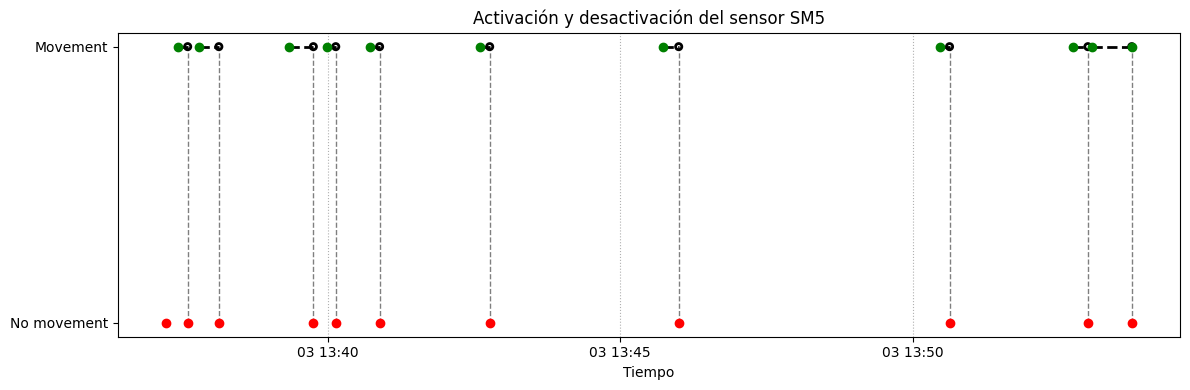

In [43]:
graf_open_close_sensor(2, 'B', 'SM5')

Como se puede apreciar hay algunos errores, como por ejemplo que empieza por una lectura de `No movement` y la última lectura de `Movement` no se llega a cerrar. Sin embargo, si se observa el mismo día en el momento `C` para el mismo sensor, empieza con un `No movement` por lo que se puede intuir que ha estado en el sofá todo ese tiempo. Se muestra ahora la misma gráfica para el momento `C`.

**Gráfica de estados: sensor `SM5`, día 03-11-2017, B**

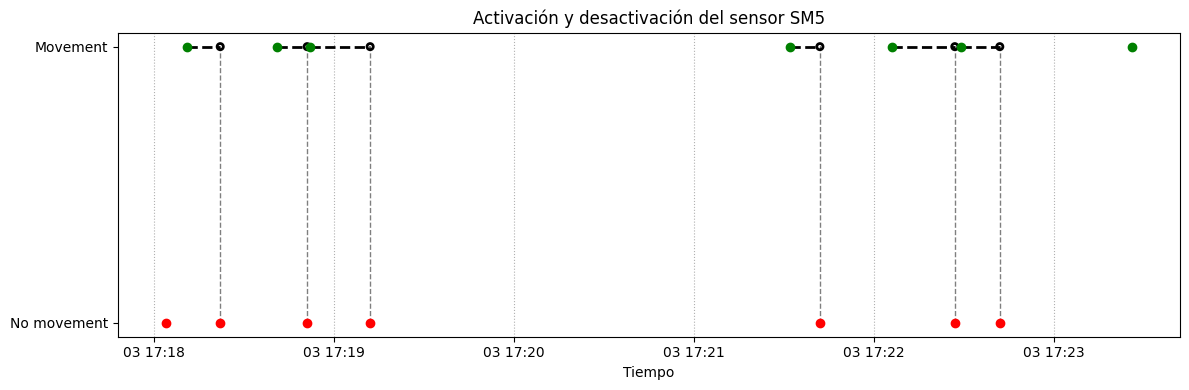

In [44]:
graf_open_close_sensor(2, 'C', 'SM5')

Entonces, a la hora de limpiar estos datos se deben tener estas cosas en cuenta, y tal vez considerar estos datos como el sensor en activación. Limpiar bien estos datos y hacer algo coherente es de gran importancia, ya que sino no se podrá sacar a la luz las relaciones de causalidad que interesan. 

Todo esto se trata en la siguiente sección de limpieza de datos.

<hr style="color:#DA01B5">

## Limpieza de los datos


<hr style="color:#DA01B5">

<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;">Sensores</h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>

Ya se ha visto la presencia de algunas anomalías en los sensores por lo que se busca eliminar esos errores para poder hacer una correcta preparación de los datos. Lo primero que se hace es eliminar estados consecutivos, es decir, si ya estaba abierto no puede volver a leer que está abierto. 

En el siguiente gráfico se puede observar la presencia de estas anomalías para el sensor `C14` el día `31-10-2017` en el momento `A`.

**Gráfica de estados: sensor `C14`, día 31-10-2017, A**

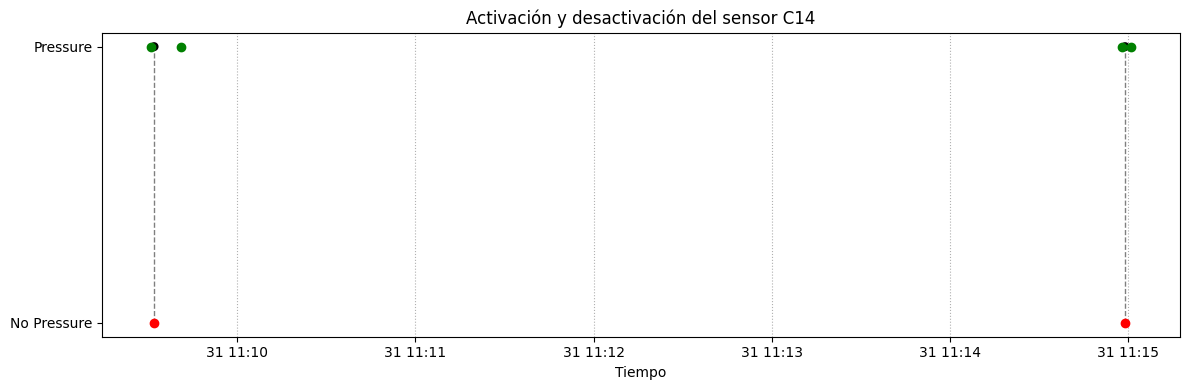

In [45]:
graf_open_close_sensor(0,'A','C14')

Para solucionar este problema, se crea la función `estados_consecutivos`, que para un data frame de sensores devuelve los tiempos en que ha habido una lectura consecutiva. 

In [46]:
# Miramos los sensores que tenemos
def sensors(DF):
    return list(set(DF['OBJECT']))

# Para cada sensor analizamos si se activan y dejan de activar correctamente
def estados_consecutivos(DF, sensors):
    # Para cada sensor, creamos un diccionario que almacena los sensores con lecturas erróneas.
    EC = {sensor: [] for sensor in sensors}
    for sensor in sensors:
        object, state, time = list(DF['OBJECT']), list(DF['STATE']), list(DF['TIMESTAMP'])

        last_state = -1
        for i in range(len(object)):
            # Si el objeto es el sensor que estamos analizando
            if object[i] == sensor:

                if last_state == -1: 
                    last_state = i

                elif state[last_state] != state[i]:
                    # Si el estado ha cambiado nos situamos en el siguiente intervalo
                    last_state = i

                elif state[last_state] == state[i]:
                    # Si el estado no ha cambiado --> hay un error en la lectura
                    EC[sensor].append((time[i], state[i]))

    
    for sensor in sensors:
        # Eliminamos los sensores que no tienen errores de lectura
        if len(EC[sensor]) == 0: del EC[sensor]
    return EC

**ERRORES DE ESTADOS CONSECUTIVOS**

In [47]:
for i in range(7):
    print(f'\033[92;1mDIA {days[i]}:\033[0m')
    for letter in ['A', 'B', 'C']:
        DF = load_file(days[i],letter,'sensors')
        sensores = sensors(DF)
        EC = estados_consecutivos(DF,sensores)
        s = ''
        for k in list(EC.keys()): 
            s += f"\033[1m Sensor {k}:\033[0m\033[1;33m #errores: {len(EC[k]):2d}\033[0m |" 
        if s == '':
            s = "\033[1;32mNo hay errores\033[0m"
        print(f"\033[1;34m{letter}:\033[0m", s)



DIA 2017-10-31:
A:  Sensor SM4: #errores:  3 | Sensor SM1: #errores:  2 | Sensor SM3: #errores:  1 | Sensor C14: #errores:  1 |
B:  Sensor SM4: #errores:  4 | Sensor SM1: #errores:  1 | Sensor D07: #errores:  1 | Sensor C09: #errores:  1 |
C:  Sensor SM4: #errores:  2 | Sensor SM1: #errores:  1 | Sensor C04: #errores:  1 | Sensor C14: #errores:  2 |
DIA 2017-11-02:
A:  Sensor SM4: #errores:  1 | Sensor SM1: #errores:  1 | Sensor C14: #errores:  2 |
B:  Sensor SM4: #errores:  2 | Sensor SM1: #errores:  1 | Sensor C09: #errores:  1 |
C:  Sensor C01: #errores:  1 | Sensor SM1: #errores:  1 | Sensor D02: #errores:  1 |
DIA 2017-11-03:
A:  Sensor SM4: #errores:  4 | Sensor SM1: #errores:  1 | Sensor SM3: #errores:  2 |
B:  Sensor SM4: #errores:  3 | Sensor SM1: #errores:  1 | Sensor C01: #errores:  1 | Sensor D05: #errores:  1 | Sensor C09: #errores:  1 |
C: No hay errores
DIA 2017-11-08:
A:  Sensor SM4: #errores:  1 | Sensor SM1: #errores:  3 | Sensor C14: #errores:  5 |
B: No hay errores


In [48]:
# Eliminamos las lecturas erróneas de los sensores
for i in range(7):
    for letter in ['A', 'B', 'C']:
        DF = pd.read_csv(f'..\\Data\\Training\\{days[i]}\\{days[i]}-{letter}\\{days[i]}-{letter}-sensors.csv', sep=';') 
        sensores = sensors(DF)
        EC = estados_consecutivos(DF,sensores)
        keys = EC.keys()
        for k in keys:
            tiempos_erroneos = EC[k]
            for t in tiempos_erroneos:
                DF = DF[~((DF['TIMESTAMP'] == t[0]) & (DF['OBJECT'] == k) & (DF['STATE'] == t[1]))]
            
        if not os.path.exists(f'..\\Data\\Training2\\{days[i]}\\{days[i]}-{letter}'): 
            os.makedirs(f'..\\Data\\Training2\\{days[i]}\\{days[i]}-{letter}')
            
        DF.to_csv(f'..\\Data\\Training2\\{days[i]}\\{days[i]}-{letter}\\{days[i]}-{letter}-sensors.csv',sep=';', index=False)
        shutil.copy(f'..\\Data\\Training\\{days[i]}\\{days[i]}-{letter}\\{days[i]}-{letter}-activity.csv', f'..\\Data\\Training2\\{days[i]}\\{days[i]}-{letter}\\{days[i]}-{letter}-activity.csv')
        shutil.copy(f'..\\Data\\Training\\{days[i]}\\{days[i]}-{letter}\\{days[i]}-{letter}-acceleration.csv', f'..\\Data\\Training2\\{days[i]}\\{days[i]}-{letter}\\{days[i]}-{letter}-acceleration.csv')
        shutil.copy(f'..\\Data\\Training\\{days[i]}\\{days[i]}-{letter}\\{days[i]}-{letter}-floor.csv', f'..\\Data\\Training2\\{days[i]}\\{days[i]}-{letter}\\{days[i]}-{letter}-floor.csv')
        shutil.copy(f'..\\Data\\Training\\{days[i]}\\{days[i]}-{letter}\\{days[i]}-{letter}-proximity.csv', f'..\\Data\\Training2\\{days[i]}\\{days[i]}-{letter}\\{days[i]}-{letter}-proximity.csv')

In [49]:
for i in range(7):
    print(f'\033[92;1mDIA {days[i]}:\033[0m')
    for letter in ['A', 'B', 'C']:
        DF = pd.read_csv(f'..\\Data\\Training2\\{days[i]}\\{days[i]}-{letter}\\{days[i]}-{letter}-sensors.csv', sep=';')
        sensores = sensors(DF)
        EC = estados_consecutivos(DF,sensores)
        s = ''
        for k in list(EC.keys()): 
            s += f"\033[1m Sensor {k}:\033[0m\033[1;33m #errores: {0 if len(EC[k]) < 10 else ''}{len(EC[k])}\033[0m |" 
        if s == '':
            s = "\033[1;32mNo hay errores\033[0m"
        print(f"\033[1;34m{letter}:\033[0m", s)


DIA 2017-10-31:
A: No hay errores
B: No hay errores
C: No hay errores
DIA 2017-11-02:
A: No hay errores
B: No hay errores
C: No hay errores
DIA 2017-11-03:
A: No hay errores
B: No hay errores
C: No hay errores
DIA 2017-11-08:
A: No hay errores
B: No hay errores
C: No hay errores
DIA 2017-11-10:
A: No hay errores
B: No hay errores
C: No hay errores
DIA 2017-11-15:
A: No hay errores
B: No hay errores
C: No hay errores
DIA 2017-11-20:
A: No hay errores
B: No hay errores
C: No hay errores


Ahora ya se han eliminado este tipo de errores. El caso de que empiece en cerrado o termine en abierto no se considera como error, sino que se interpreta como que llevaba abierto desde antes de que los tiempos estuviesen registrados o que todavía no ha terminado. 

**Gráfica de estados: sensor `C14`, día 31-10-2017, A**

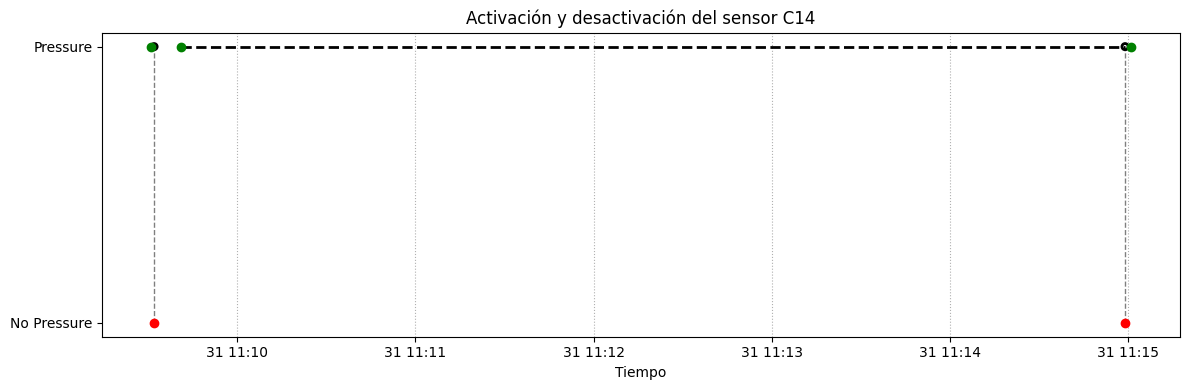

In [50]:
graf_open_close_sensor(0,'A','C14',dset='Training2')

<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;">Floor</h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>

In [51]:
r"""
for i in range(len(days)):
    for letter in ['A', 'B', 'C']:
        
        # Paths
        base_in = f'..\\Data\\Training\\{days[i]}\\{days[i]}-{letter}'
        base_out = f'..\\Data\\Training2\\{days[i]}\\{days[i]}-{letter}'
        
        # Crear carpeta de salida
        os.makedirs(base_out, exist_ok=True)
        
        # --- Filtrado de floor ---
        floor_path = f'{base_in}\\{days[i]}-{letter}-floor.csv'
        df_floor = pd.read_csv(floor_path, sep=';')
        
        # Quitar valores nulos o vacíos
        df_floor = df_floor[df_floor['DEVICE'].notna() & (df_floor['DEVICE'].str.strip() != '')]
        
        # Separar X, Y
        coords = df_floor['DEVICE'].str.split(',', expand=True)
        coords = coords.apply(pd.to_numeric, errors='coerce')
        df_floor['X'] = coords[0]
        df_floor['Y'] = coords[1]
        
        # Eliminar filas inválidas
        df_floor = df_floor.dropna(subset=['X', 'Y']).astype({'X': int, 'Y': int})
        
        # Calcular saltos
        df_floor['dx'] = df_floor['X'].diff().abs()
        df_floor['dy'] = df_floor['Y'].diff().abs()
        
        # Filtrar saltos válidos
        df_floor_filtrado = df_floor[
            df_floor['dx'].isna() | ((df_floor['dx'] <= 1) & (df_floor['dy'] <= 1))
        ].copy()
        
        # Quitar columnas auxiliares
        df_floor_filtrado = df_floor_filtrado.drop(columns=['dx', 'dy', 'X', 'Y'])
        
        # Guardar floor filtrado
        df_floor_filtrado.to_csv(f'{base_out}\\{days[i]}-{letter}-floor.csv', sep=';', index=False)
        
                # --- Guardar floor filtrado ---
        df_floor_filtrado.to_csv(f'{base_out}\\{days[i]}-{letter}-floor.csv', sep=';', index=False)
"""

"\nfor i in range(len(days)):\n    for letter in ['A', 'B', 'C']:\n        \n        # Paths\n        base_in = f'..\\\\Data\\\\Training\\\\{days[i]}\\\\{days[i]}-{letter}'\n        base_out = f'..\\\\Data\\\\Training2\\\\{days[i]}\\\\{days[i]}-{letter}'\n        \n        # Crear carpeta de salida\n        os.makedirs(base_out, exist_ok=True)\n        \n        # --- Filtrado de floor ---\n        floor_path = f'{base_in}\\\\{days[i]}-{letter}-floor.csv'\n        df_floor = pd.read_csv(floor_path, sep=';')\n        \n        # Quitar valores nulos o vacíos\n        df_floor = df_floor[df_floor['DEVICE'].notna() & (df_floor['DEVICE'].str.strip() != '')]\n        \n        # Separar X, Y\n        coords = df_floor['DEVICE'].str.split(',', expand=True)\n        coords = coords.apply(pd.to_numeric, errors='coerce')\n        df_floor['X'] = coords[0]\n        df_floor['Y'] = coords[1]\n        \n        # Eliminar filas inválidas\n        df_floor = df_floor.dropna(subset=['X', 'Y']).astyp